<a href="https://colab.research.google.com/github/micah-shull/pipelines/blob/main/pipelines_07_pytorch_pipeline_11_hyperparameter_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction to Hyperparameter Tuning

#### What are Hyperparameters?

In machine learning, hyperparameters are parameters that are set before the learning process begins. They control the behavior of the learning algorithm and influence the model's performance. Unlike model parameters (e.g., weights in a neural network), hyperparameters are not learned from the data during training. Examples of hyperparameters include:

- **Learning Rate**: Controls how much to change the model in response to the estimated error each time the model weights are updated.
- **Number of Epochs**: The number of complete passes through the training dataset.
- **Batch Size**: The number of training examples used in one iteration.
- **Network Architecture**: The number of layers and number of neurons per layer in a neural network.
- **Regularization Parameters**: Parameters like dropout rate or L2 regularization that help prevent overfitting.

#### Why is Hyperparameter Tuning Important?

Hyperparameter tuning is crucial because it directly affects the performance and generalizability of a machine learning model. Poorly chosen hyperparameters can lead to:

- **Overfitting**: The model performs well on training data but poorly on unseen data.
- **Underfitting**: The model is too simple to capture the underlying patterns in the data.
- **Slow Convergence**: Training takes longer than necessary due to inefficient learning rates or batch sizes.
- **Poor Performance**: The model's overall accuracy, precision, recall, or other metrics are suboptimal.

#### Methods for Hyperparameter Tuning

1. **Grid Search**:
   - **Definition**: An exhaustive search over a specified parameter grid.
   - **Process**: Defines a set of hyperparameters and their possible values, then evaluates the model performance for all possible combinations.
   - **Advantages**: Simple to understand and implement.
   - **Disadvantages**: Computationally expensive, especially for large grids and datasets.

2. **Random Search**:
   - **Definition**: Randomly samples hyperparameters from a specified distribution.
   - **Process**: Defines a range for each hyperparameter and randomly picks combinations to evaluate.
   - **Advantages**: Often finds good hyperparameter combinations with less computation than grid search.
   - **Disadvantages**: Still may require a significant number of evaluations for large hyperparameter spaces.

3. **Bayesian Optimization**:
   - **Definition**: Uses probabilistic models to find the optimal hyperparameters.
   - **Process**: Builds a probabilistic model of the objective function and uses it to select the most promising hyperparameters to evaluate.
   - **Advantages**: Efficient and effective for high-dimensional hyperparameter spaces.
   - **Disadvantages**: More complex to implement and understand.

4. **Gradient-Based Optimization**:
   - **Definition**: Uses gradient information to optimize hyperparameters.
   - **Process**: Adjusts hyperparameters based on the gradient of the performance metric with respect to the hyperparameters.
   - **Advantages**: Can be very efficient for certain types of models.
   - **Disadvantages**: Not applicable to all types of models and hyperparameters.

5. **Automated Hyperparameter Tuning Tools**:
   - **Examples**: HyperOpt, Optuna, AutoKeras, Auto-sklearn.
   - **Advantages**: These tools often combine several advanced techniques to find optimal hyperparameters efficiently.
   - **Disadvantages**: May require some setup and understanding of the tool.

#### Key Considerations for Hyperparameter Tuning

- **Performance Metric**: Choose an appropriate performance metric (e.g., F1 score, accuracy, AUC) that aligns with the business or research goals.
- **Computational Resources**: Balance the thoroughness of the search with the available computational resources and time.
- **Validation Strategy**: Use cross-validation or a separate validation set to ensure the hyperparameter tuning results generalize well to unseen data.

### Summary

Hyperparameter tuning is a critical step in the machine learning pipeline that helps optimize model performance and generalizability. By carefully selecting and tuning hyperparameters, you can significantly enhance your model's effectiveness and efficiency.

### Load and Preprocess the Data

In [7]:
# Import necessary libraries
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns

# Import custom modules
from data_utils import (
    load_data_from_url, clean_column_names, remove_id_column, rename_columns,
    convert_categorical, split_data, preprocess_data, define_preprocessor,
    calculate_class_weights, convert_to_tensors, load_and_preprocess_data
)
from model_definition import SklearnSimpleNN, SimpleNN
from model_pipeline import (
    apply_feature_engineering, SklearnSimpleNN, train_model, evaluate_model
)
from feature_engineering import (
    create_interaction_features, create_payment_to_bill_ratios,
    create_payment_to_limit_ratios, create_bill_to_limit_ratios,
    create_lagged_payment_differences, create_debt_ratio_features,
    create_average_payment_and_bill, create_payment_timeliness_features,
    create_total_payment_and_bill, create_bill_difference_features,
    bin_features, target_encode
)
from resampling_utils import (
    run_resampling_pipeline, reports_to_dataframe, apply_feature_set, plot_metric
)
from model_evaluation import evaluate_class_weights, class_weights_to_dataframe

# Define Global Parameters
best_class_weight = 3.0
best_lower_threshold = 0.40

# Load and Preprocess Data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
categorical_columns = ['sex', 'education', 'marriage']  # Specify your categorical columns
target = 'default_payment_next_month'  # Specify your target column

data, target = load_and_preprocess_data(url, categorical_columns, target)

# Apply feature engineering
data = apply_feature_engineering(data)

# Split the data
X_train, X_test, y_train, y_test = split_data(data, target=target)

### What is Learning Rate?

The **learning rate** is a hyperparameter that controls how much to change the model's parameters (e.g., weights) in response to the estimated error each time the model weights are updated. It determines the size of the steps taken during gradient descent optimization.

#### Impact of Learning Rate on Training

1. **Too High Learning Rate**:
   - **Overshooting**: If the learning rate is too high, the optimization process may overshoot the optimal parameters, leading to oscillations or divergence.
   - **Unstable Training**: High learning rates can cause the model to become unstable and fail to converge.

2. **Too Low Learning Rate**:
   - **Slow Convergence**: If the learning rate is too low, the model will update the parameters very slowly, leading to prolonged training times.
   - **Local Minima**: Low learning rates may also cause the model to get stuck in local minima, preventing it from finding the global optimum.

3. **Optimal Learning Rate**:
   - **Efficient Convergence**: An appropriately chosen learning rate will allow the model to converge efficiently to the optimal parameters.
   - **Balanced Training**: The right learning rate balances the speed of convergence with the stability of the training process.

#### Techniques for Adjusting Learning Rate

1. **Learning Rate Schedules**:
   - **Fixed Schedule**: Predefined adjustments to the learning rate at specific epochs (e.g., reducing the learning rate by half every 10 epochs).
   - **Exponential Decay**: Gradually decreases the learning rate according to an exponential decay function.
   - **Step Decay**: Reduces the learning rate by a factor at specific intervals.
   - **Piecewise Constant Decay**: Applies different fixed learning rates for different ranges of epochs.

2. **Adaptive Learning Rate Methods**:
   - **AdaGrad**: Adjusts the learning rate based on the historical gradients.
   - **RMSprop**: Uses a moving average of squared gradients to normalize the gradient.
   - **Adam**: Combines the ideas of AdaGrad and RMSprop by maintaining a moving average of both the gradients and their squares.

#### Practical Tips for Choosing Learning Rate

1. **Start with a Range**: Experiment with a range of learning rates (e.g., 0.001, 0.01, 0.1) to find a good starting point.
2. **Learning Rate Finder**: Use techniques like learning rate finder, which gradually increases the learning rate during training and plots the loss to identify the optimal range.
3. **Monitor Training**: Keep an eye on training and validation loss curves to detect signs of instability (too high) or slow convergence (too low).
4. **Adjust Dynamically**: Be prepared to adjust the learning rate dynamically based on the training progress.

### Summary

The learning rate is a crucial hyperparameter that significantly affects the training process of a machine learning model. Finding the right learning rate involves balancing the speed of convergence with the stability of the training process. By understanding the impact of the learning rate and using appropriate techniques to adjust it, you can improve the efficiency and effectiveness of your model training.

Next, we can explore another hyperparameter, such as the number of epochs or batch size. Let me know which one you would like to learn about next!

#### Define and Evaluate Learning Rates

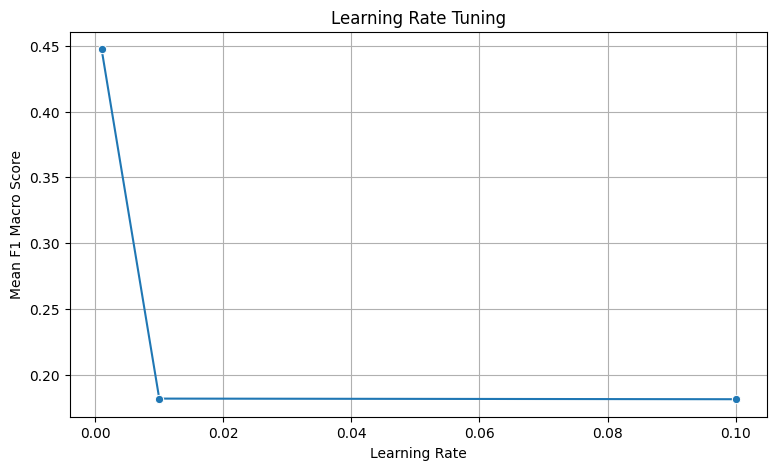

In [6]:
# Define a range of learning rates
learning_rates = [0.001, 0.01, 0.1]

# Store the results
learning_rate_results = []

# Perform cross-validation for each learning rate
for lr in learning_rates:
    # Define the neural network estimator with the current learning rate
    nn_estimator = SklearnSimpleNN(input_dim=X_train.shape[1], learning_rate=lr, pos_weight=best_class_weight, threshold=best_lower_threshold)

    # Perform cross-validation
    scores = cross_val_score(nn_estimator, X_train, y_train, cv=5, scoring='f1_macro')
    mean_score = np.mean(scores)

    # Store the results
    learning_rate_results.append({'learning_rate': lr, 'f1_macro_mean': mean_score})

# Convert results to DataFrame
learning_rate_results_df = pd.DataFrame(learning_rate_results)

# Plot the results
plt.figure(figsize=(9,5))
sns.lineplot(data=learning_rate_results_df, x='learning_rate', y='f1_macro_mean', marker='o')
plt.xlabel('Learning Rate')
plt.ylabel('Mean F1 Macro Score')
plt.title('Learning Rate Tuning')
plt.grid(True)
plt.show()


In [4]:
print(learning_rate_results_df)

   learning_rate  f1_macro_mean
0          0.001       0.447473
1          0.010       0.181742
2          0.100       0.181266


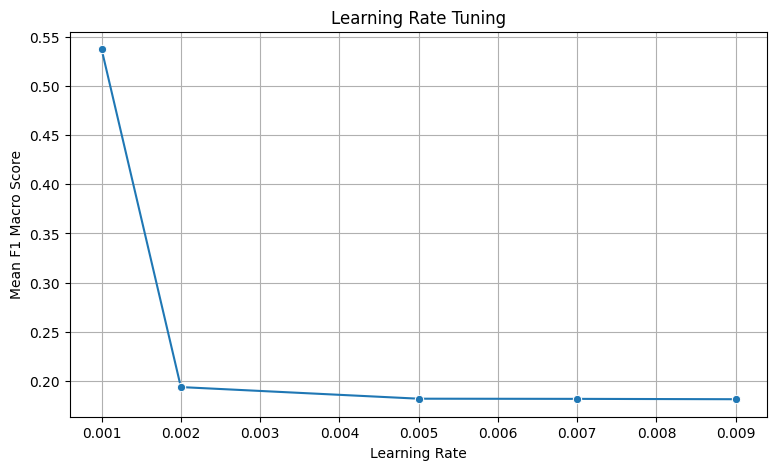

In [7]:
# Define a finer range of learning rates below 0.010
learning_rates = [0.001, 0.002, 0.005, 0.007, 0.009]

# Store the results
learning_rate_results = []

# Perform cross-validation for each learning rate
for lr in learning_rates:
    # Define the neural network estimator with the current learning rate
    nn_estimator = SklearnSimpleNN(input_dim=X_train.shape[1], learning_rate=lr, pos_weight=best_class_weight, threshold=best_lower_threshold)

    # Perform cross-validation
    scores = cross_val_score(nn_estimator, X_train, y_train, cv=5, scoring='f1_macro')
    mean_score = np.mean(scores)

    # Store the results
    learning_rate_results.append({'learning_rate': lr, 'f1_macro_mean': mean_score})

# Convert results to DataFrame
learning_rate_results_df = pd.DataFrame(learning_rate_results)

# Plot the results
plt.figure(figsize=(9,5))
sns.lineplot(data=learning_rate_results_df, x='learning_rate', y='f1_macro_mean', marker='o')
plt.xlabel('Learning Rate')
plt.ylabel('Mean F1 Macro Score')
plt.title('Learning Rate Tuning')
plt.grid(True)
plt.show()


In [8]:
learning_rate_results_df

,learning_rate,f1_macro_mean
0,0.001,0.537423
1,0.002,0.193744
2,0.005,0.181920
3,0.007,0.181746
4,0.009,0.181385


#### Learning Rate Results

The results indicate that the learning rate significantly impacts the performance of your model, as measured by the mean F1 macro score. Here's an interpretation of the results:

- **0.001:** The mean F1 macro score is **0.537423**, which is significantly higher than the scores for the other learning rates. This indicates that a learning rate of 0.001 is optimal for your model, providing the best balance between precision and recall.
- **0.002:** The mean F1 macro score drops sharply to **0.193744**. This suggests that the learning rate is too high, causing the model to converge too quickly and possibly miss the optimal solution.
- **0.005:** The mean F1 macro score further decreases to **0.181920**, indicating that this learning rate is too high and the model performance is poor.
- **0.007:** The mean F1 macro score is **0.181746**, which is very close to the score for the 0.005 learning rate. This suggests that the learning rate is still too high and not suitable for the model.
- **0.009:** The mean F1 macro score is **0.181385**, showing no significant improvement and confirming that this learning rate is too high.

### Conclusion

- **Optimal Learning Rate:** The learning rate of **0.001** is the best choice for your model, as it yields the highest mean F1 macro score.
- **Learning Rate Sensitivity:** Your model is sensitive to changes in the learning rate. Small increases above 0.001 lead to a significant drop in performance.
- **Next Steps:** You can proceed with the learning rate of 0.001 for further model tuning and evaluation. If desired, you can also test learning rates slightly below 0.001 to see if there is any further improvement.

This fine-tuning ensures that your model's learning process is stable and effective, leading to better performance in predicting loan defaults.

### What is Batch Size?

**Batch size** is a hyperparameter that determines the number of training samples to work through before updating the model's internal parameters. In the context of training a neural network, it controls the number of samples that the model processes in one go.

### How Batch Size Relates to Model Performance

1. **Batch Size and Gradient Estimation:**
   - **Small Batch Size:** When the batch size is small, the model updates its weights frequently, but with high variance in the gradient estimates. This can lead to a more stable convergence to the global minimum but can also cause noisy updates and may take longer to converge.
   - **Large Batch Size:** With a larger batch size, the gradient estimates are more accurate, leading to smoother updates. However, larger batches require more memory and computational power. They also tend to provide less frequent updates, which might miss some of the finer details in the data, potentially leading to suboptimal convergence.

2. **Training Stability and Efficiency:**
   - **Small Batch Size:** Provides more stable and frequent updates but is computationally intensive and slower per epoch due to more updates.
   - **Large Batch Size:** Faster per epoch due to fewer updates, but requires more memory and may lead to less precise updates, which can sometimes result in poor generalization.

3. **Generalization and Overfitting:**
   - **Small Batch Size:** May help in better generalization due to the noisy updates that can act as a form of regularization.
   - **Large Batch Size:** May lead to overfitting if the model learns the training data too well but fails to generalize to unseen data.

4. **Impact on Convergence:**
   - **Small Batch Size:** Can lead to slow convergence due to high variance in updates.
   - **Large Batch Size:** Can lead to faster convergence initially, but might converge to a suboptimal solution due to less frequent updates.

### Choosing the Batch Size

The optimal batch size often depends on the specific problem and the computational resources available. It is generally chosen by experimentation and cross-validation to find a balance between computational efficiency and model performance.



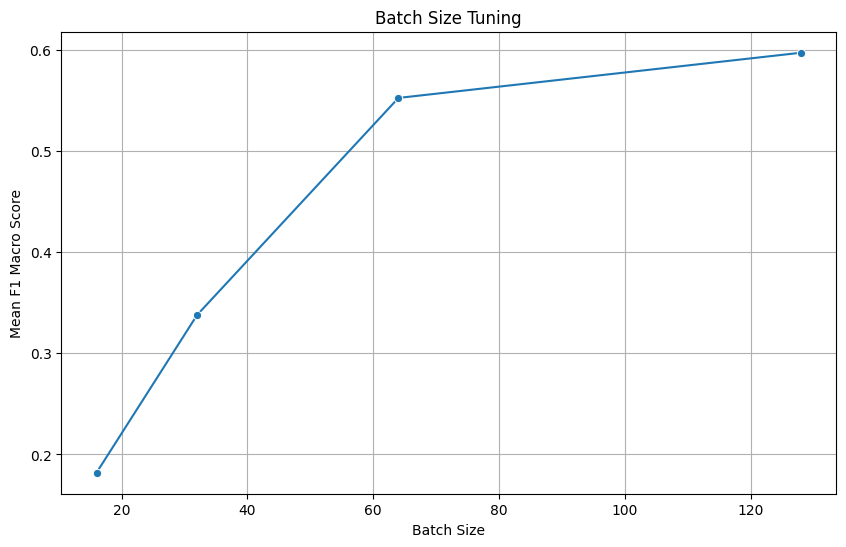

In [9]:
# Define a range of batch sizes
batch_sizes = [16, 32, 64, 128]

# Store the results
batch_size_results = []

# Perform cross-validation for each batch size
for bs in batch_sizes:
    # Define the neural network estimator with the current batch size
    nn_estimator = SklearnSimpleNN(input_dim=X_train.shape[1], learning_rate=0.001, batch_size=bs, pos_weight=best_class_weight, threshold=best_lower_threshold)

    # Perform cross-validation
    scores = cross_val_score(nn_estimator, X_train, y_train, cv=5, scoring='f1_macro')
    mean_score = np.mean(scores)

    # Store the results
    batch_size_results.append({'batch_size': bs, 'f1_macro_mean': mean_score})

# Convert results to DataFrame
batch_size_results_df = pd.DataFrame(batch_size_results)

# Plot the results
plt.figure(figsize=(10, 6))
sns.lineplot(data=batch_size_results_df, x='batch_size', y='f1_macro_mean', marker='o')
plt.xlabel('Batch Size')
plt.ylabel('Mean F1 Macro Score')
plt.title('Batch Size Tuning')
plt.grid(True)
plt.show()


In [10]:
batch_size_results_df

,batch_size,f1_macro_mean
0,16,0.181949
1,32,0.337922
2,64,0.552394
3,128,0.597077


#### Analysis of Batch Size Results

1. **Batch Size 16:** The F1 Macro Mean is quite low, indicating that the model's performance is suboptimal with this small batch size.
2. **Batch Size 32:** There is an improvement in the F1 Macro Mean, but it's still not very high.
3. **Batch Size 64:** The F1 Macro Mean increases significantly, suggesting that the model performs better with a larger batch size.
4. **Batch Size 128:** The F1 Macro Mean is the highest at this batch size, indicating the best performance among the tested batch sizes.

### Recommendations

Based on the results, the batch size of 128 yields the best performance in terms of the F1 Macro Mean score. This suggests that using a larger batch size is beneficial for your model.

### Next Steps

1. **Confirming Results:**
   - It's always good to confirm the results with a few more trials to ensure consistency.
   - You can also test a few more values around 128 to see if there is an even better batch size (e.g., 100, 150).

2. **Other Hyperparameters:**
   - Continue tuning other hyperparameters such as the number of epochs, learning rate, and network architecture.

3. **Final Evaluation:**
   - Once the hyperparameters are tuned, perform a final evaluation on a separate test set to confirm the model's performance.



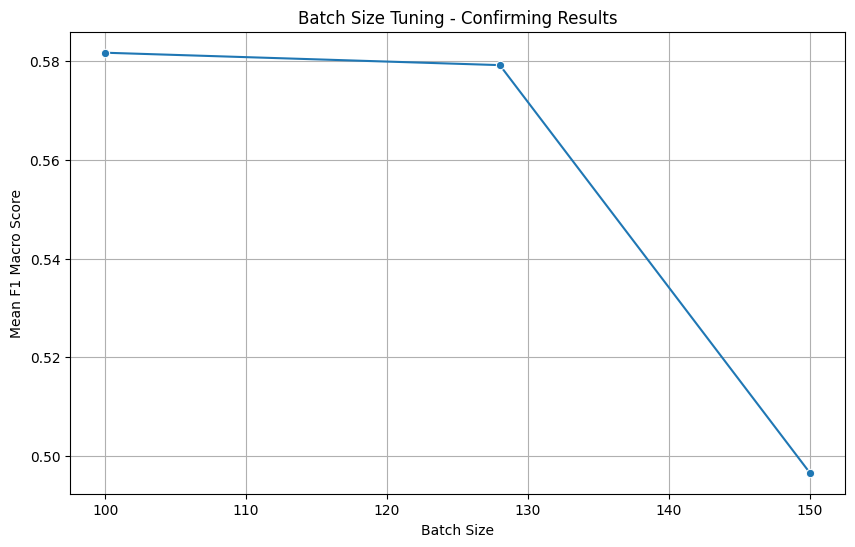

In [11]:
# Define a range of batch sizes around the best performing one
batch_sizes = [100, 128, 150]

# Store the results
batch_size_results = []

# Perform cross-validation for each batch size
for bs in batch_sizes:
    # Define the neural network estimator with the current batch size
    nn_estimator = SklearnSimpleNN(input_dim=X_train.shape[1], learning_rate=0.001, batch_size=bs, pos_weight=best_class_weight, threshold=best_lower_threshold)

    # Perform cross-validation
    scores = cross_val_score(nn_estimator, X_train, y_train, cv=5, scoring='f1_macro')
    mean_score = np.mean(scores)

    # Store the results
    batch_size_results.append({'batch_size': bs, 'f1_macro_mean': mean_score})

# Convert results to DataFrame
batch_size_results_df = pd.DataFrame(batch_size_results)

# Plot the results
plt.figure(figsize=(10, 6))
sns.lineplot(data=batch_size_results_df, x='batch_size', y='f1_macro_mean', marker='o')
plt.xlabel('Batch Size')
plt.ylabel('Mean F1 Macro Score')
plt.title('Batch Size Tuning - Confirming Results')
plt.grid(True)
plt.show()


In [12]:
batch_size_results_df

,batch_size,f1_macro_mean
0,100,0.581696
1,128,0.579185
2,150,0.496615


#### Interpretation of Confirmed Batch Size Results

1. **Batch Size 100:** The F1 Macro Mean is the highest at 0.581696, indicating strong model performance with this batch size.
2. **Batch Size 128:** The F1 Macro Mean is slightly lower at 0.579185, but still very close to the best performing batch size of 100.
3. **Batch Size 150:** The F1 Macro Mean drops significantly to 0.496615, suggesting that this larger batch size negatively impacts model performance.

### Recommendations

Based on these results, the batch size of 100 appears to provide the best model performance. While batch size 128 also performs well, it is slightly less optimal compared to 100.

### Next Steps

1. **Select Optimal Batch Size:**
   - Use a batch size of 100 for further training and model evaluation.

2. **Continue Hyperparameter Tuning:**
   - Proceed with tuning other hyperparameters such as the number of epochs, learning rate, and network architecture.
   - Ensure each parameter is tested thoroughly to find the optimal configuration.

3. **Final Model Training:**
   - Once all hyperparameters are tuned, train the final model using the full training dataset and evaluate its performance on a separate validation set to ensure consistency and reliability.



### What are Epochs?

- **Epochs:** An epoch is one complete pass through the entire training dataset. Increasing the number of epochs allows the model to learn and adjust weights multiple times, potentially improving performance. However, too many epochs can lead to overfitting.



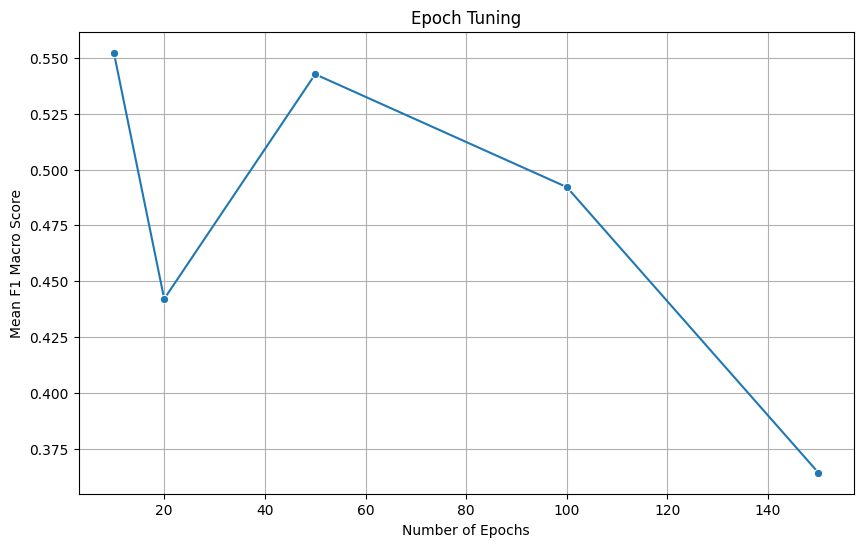

In [13]:
# Define a range of epochs
epoch_values = [10, 20, 50, 100, 150]

# Store the results
epoch_results = []

# Perform cross-validation for each epoch value
for epochs in epoch_values:
    # Define the neural network estimator with the current number of epochs
    nn_estimator = SklearnSimpleNN(input_dim=X_train.shape[1], learning_rate=0.001, batch_size=100, epochs=epochs, pos_weight=best_class_weight, threshold=best_lower_threshold)

    # Perform cross-validation
    scores = cross_val_score(nn_estimator, X_train, y_train, cv=5, scoring='f1_macro')
    mean_score = np.mean(scores)

    # Store the results
    epoch_results.append({'epochs': epochs, 'f1_macro_mean': mean_score})

# Convert results to DataFrame
epoch_results_df = pd.DataFrame(epoch_results)

# Plot the results
plt.figure(figsize=(10, 6))
sns.lineplot(data=epoch_results_df, x='epochs', y='f1_macro_mean', marker='o')
plt.xlabel('Number of Epochs')
plt.ylabel('Mean F1 Macro Score')
plt.title('Epoch Tuning')
plt.grid(True)
plt.show()


In [14]:
epoch_results_df

,epochs,f1_macro_mean
0,10,0.552336
1,20,0.442082
2,50,0.542695
3,100,0.492135
4,150,0.364216


#### Analysis of Epoch Results

1. **Epochs = 10**: The F1 macro mean score is the highest at 0.552336, indicating that the model performs best with this number of epochs. This suggests that the model reaches an optimal balance of learning and avoiding overfitting within just 10 epochs.

2. **Epochs = 20**: The F1 macro mean score drops to 0.442082. This indicates that as the number of epochs increases, the model starts to overfit the training data, resulting in decreased performance on the validation data.

3. **Epochs = 50**: The F1 macro mean score slightly increases to 0.542695 but is still lower than the score for 10 epochs. This suggests that while some additional learning is happening, it is not significantly beneficial, and overfitting may still be an issue.

4. **Epochs = 100**: The F1 macro mean score decreases further to 0.492135, indicating that with more epochs, overfitting becomes more pronounced, leading to reduced performance.

5. **Epochs = 150**: The F1 macro mean score drops significantly to 0.364216. This suggests that the model is significantly overfitting to the training data with 150 epochs, leading to poor generalization on the validation data.

### Recommendation:

- **Optimal Epochs**: Based on the results, 10 epochs seem to provide the best balance of training without overfitting. This setting offers the highest F1 macro mean score, suggesting optimal model performance.
- **Avoid Higher Epochs**: Higher numbers of epochs lead to decreased performance, indicating overfitting. Therefore, it's better to avoid using 20, 50, 100, or 150 epochs in this case.

Given these observations, the optimal number of epochs for your model appears to be **10**.

### Next Steps:
You can proceed with tuning other hyperparameters or consider refining the model architecture. Given that changes in architecture might affect these hyperparameters, it's advisable to finalize the architecture before performing exhaustive tuning.

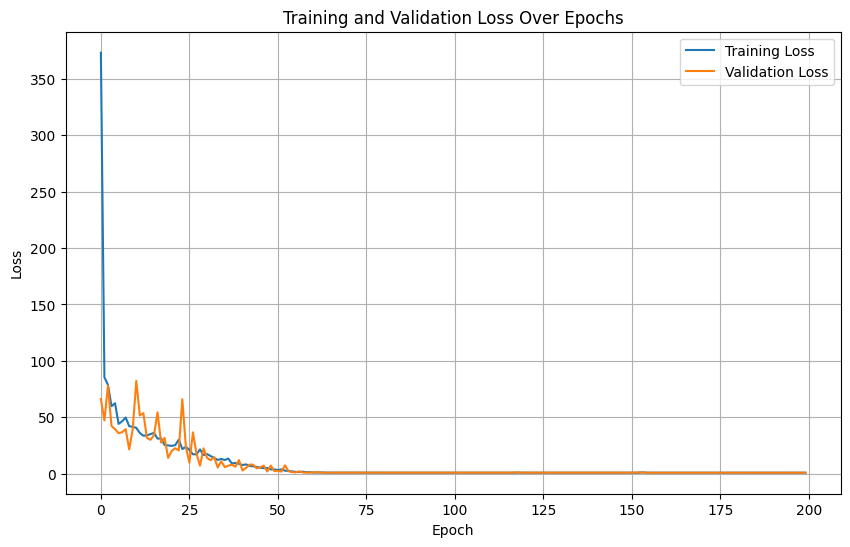

In [17]:
from sklearn.base import BaseEstimator, ClassifierMixin

class SklearnSimpleNN(BaseEstimator, ClassifierMixin):
    def __init__(self, input_dim, learning_rate=0.001, epochs=50, batch_size=64,
                 pos_weight=1.0, threshold=0.5):
        self.input_dim = input_dim
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.pos_weight = pos_weight
        self.threshold = threshold
        self.model = SimpleNN(self.input_dim)
        self.train_losses = []
        self.val_losses = []

    def fit(self, X, y, X_val=None, y_val=None):
        if isinstance(X, pd.DataFrame):
            X = X.values
        if isinstance(y, pd.Series):
            y = y.values
        if X_val is not None and isinstance(X_val, pd.DataFrame):
            X_val = X_val.values
        if y_val is not None and isinstance(y_val, pd.Series):
            y_val = y_val.values

        criterion = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor(self.pos_weight, dtype=torch.float32))
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        train_dataset = torch.utils.data.TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32).unsqueeze(1))
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)

        if X_val is not None and y_val is not None:
            val_dataset = torch.utils.data.TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32).unsqueeze(1))
            val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False)
        else:
            val_loader = None

        for epoch in range(self.epochs):
            self.model.train()
            train_loss = 0
            for inputs, targets in train_loader:
                optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = criterion(outputs, targets.view(-1, 1))
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

            self.train_losses.append(train_loss / len(train_loader))

            if val_loader is not None:
                self.model.eval()
                val_loss = 0
                with torch.no_grad():
                    for inputs, targets in val_loader:
                        outputs = self.model(inputs)
                        loss = criterion(outputs, targets.view(-1, 1))
                        val_loss += loss.item()

                self.val_losses.append(val_loss / len(val_loader))

        return self

    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            if isinstance(X, pd.DataFrame):
                X = torch.tensor(X.values, dtype=torch.float32)
            elif isinstance(X, np.ndarray):
                X = torch.tensor(X, dtype=torch.float32)
            outputs = self.model(X)
            probabilities = torch.sigmoid(outputs)
            predictions = (probabilities > self.threshold).float()
        return predictions.numpy().squeeze()


# Split the data into training and validation sets
X_train, X_val, y_train, y_val = split_data(data, target=target)

# Define the neural network estimator with a high number of epochs
nn_estimator = SklearnSimpleNN(input_dim=X_train.shape[1], learning_rate=0.001, epochs=200, batch_size=64, pos_weight=best_class_weight, threshold=best_lower_threshold)

# Train the model and store losses
nn_estimator.fit(X_train, y_train, X_val, y_val)

# Plot the training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(nn_estimator.train_losses, label='Training Loss')
plt.plot(nn_estimator.val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


### Model Analysis

If the neural network model is overfitting quickly, it suggests that the model might be too complex for the given dataset. Overfitting occurs when the model learns the noise in the training data rather than the underlying patterns. A simpler model might generalize better to unseen data.

Here are some considerations and steps you can take:

1. **Reduce Model Complexity**: Simplify the model architecture by reducing the number of layers and neurons in each layer.

2. **Regularization**: Add regularization techniques like dropout, L2 regularization, or early stopping to prevent overfitting.

3. **Feature Engineering**: Review the feature engineering steps to ensure that they are adding meaningful information without introducing noise.

4. **Hyperparameter Tuning**: Continue tuning hyperparameters such as batch size, learning rate, and number of epochs to find the optimal settings for the simpler model.

5. **Alternative Models**: Consider using simpler models such as logistic regression, decision trees, or even linear models. These models might perform better on the dataset without overfitting as quickly.

### Step 1: Simplify the Model Architecture

Let's simplify the neural network model by reducing the number of layers and neurons.

```python
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 16)
        self.fc2 = nn.Linear(16, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x
```

### Step 2: Add Regularization

You can add dropout to the neural network to reduce overfitting.

```python
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 16)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(16, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
```

### Step 3: Train and Evaluate the Simplified Model

Train the simplified model and evaluate its performance.

```python
# Define the neural network estimator with the simplified architecture
nn_estimator = SklearnSimpleNN(input_dim=X_train.shape[1], learning_rate=0.001, epochs=200, batch_size=64, pos_weight=best_class_weight, threshold=best_lower_threshold)

# Train the model and store losses
nn_estimator.fit(X_train, y_train, X_val, y_val)

# Plot the training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(nn_estimator.train_losses, label='Training Loss')
plt.plot(nn_estimator.val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs (Simplified Model)')
plt.legend()
plt.grid(True)
plt.show()
```

### Step 4: Explore Alternative Models

Consider using logistic regression or decision trees for comparison.

#### Logistic Regression

```python
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Train logistic regression
log_reg = LogisticRegression(class_weight='balanced', max_iter=1000)
log_reg.fit(X_train, y_train)

# Evaluate logistic regression
y_pred = log_reg.predict(X_test)
print(classification_report(y_test, y_pred))
```

#### Decision Trees

```python
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

# Train decision tree
tree_clf = DecisionTreeClassifier(class_weight='balanced', max_depth=5)
tree_clf.fit(X_train, y_train)

# Evaluate decision tree
y_pred = tree_clf.predict(X_test)
print(classification_report(y_test, y_pred))
```

By comparing the performance of these models, you can determine whether the simpler neural network, logistic regression, or decision tree performs better on your dataset.

#### Changes to Model Architecture and Hyperparameters

Changing the model architecture can significantly affect various hyperparameters, including learning rate, batch size, and the number of epochs. Here's why:

1. **Learning Rate:**
   - Different architectures may have different sensitivities to the learning rate. A deeper or more complex model might require a smaller learning rate to converge properly without overshooting, while a simpler model might handle a larger learning rate better.

2. **Batch Size:**
   - The optimal batch size can depend on the architecture's memory requirements and computational load. More complex models may require smaller batch sizes due to higher memory usage, while simpler models might handle larger batch sizes efficiently.

3. **Number of Epochs:**
   - The number of epochs required to reach convergence can vary with the architecture. Complex models may need more epochs to learn the data adequately, while simpler models might converge faster.

### When to Rerun Hyperparameter Tuning

Whenever you change the model architecture, it's generally advisable to rerun hyperparameter tuning to find the new optimal settings. Here are some scenarios where you should retune:

- **Adding/Removing Layers:** Changing the number of layers or units within layers.
- **Changing Activation Functions:** Switching from ReLU to another activation function, for example.
- **Introducing/Removing Regularization:** Adding dropout, L2 regularization, etc.
- **Changing Network Type:** Switching from a fully connected network to a convolutional network, for instance.

### Practical Steps

1. **Change the Architecture:**
   - Update your model definition with the new architecture.

2. **Rerun Hyperparameter Tuning:**
   - Redo the tuning process for learning rate, batch size, and epochs.

### Example of Changing Model Architecture

If you decide to change the model architecture, here's an example of how you might update your `SimpleNN` class:

```python
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
```

### Rerun Hyperparameter Tuning

After updating the architecture, you would rerun the tuning processes for learning rate, batch size, and epochs:

1. **Learning Rate Tuning:**
   - Follow the same steps as before but with the updated architecture.

2. **Batch Size Tuning:**
   - Adjust the batch size and observe how it impacts performance with the new model.

3. **Epoch Tuning:**
   - Determine how many epochs are needed for the new architecture to achieve optimal performance.

### Conclusion

Model architecture changes can necessitate a full retraining of hyperparameters. It's crucial to retune these settings to ensure your model performs optimally with the new architecture.

It's generally recommended to finalize the model architecture before starting hyperparameter tuning. Here’s a step-by-step outline to help you navigate this process:

1. **Define the Baseline Model Architecture:**
   - Start with a simple model architecture based on your initial understanding of the problem.
   - Ensure it’s capable of capturing the essential patterns in the data.

2. **Baseline Training and Evaluation:**
   - Train this baseline model using default hyperparameters or reasonable guesses.
   - Evaluate its performance to understand its strengths and weaknesses.

3. **Experiment with Different Architectures:**
   - Modify the model architecture based on insights from the baseline model’s performance.
   - Try adding/removing layers, changing activation functions, etc.
   - Each architecture should be evaluated with a fixed set of hyperparameters to keep the comparison fair.

4. **Select the Best Architecture:**
   - Choose the model architecture that shows the best potential based on the evaluations.
   - This should be a balance between complexity and performance.

5. **Hyperparameter Tuning:**
   - Once the architecture is finalized, begin hyperparameter tuning.
   - Tune the learning rate, batch size, epochs, and other hyperparameters for the selected architecture.
   - Use cross-validation or other robust evaluation methods to ensure the tuning is effective.

#### Practical Workflow

1. **Initial Model Architecture:**
   - Define and train an initial model architecture.
   - Example: A simple neural network with one hidden layer.

2. **Evaluate and Modify:**
   - Train and evaluate this model.
   - Modify the architecture if necessary (e.g., add more layers, change layer sizes).
   - Evaluate the modified architectures with a fixed set of hyperparameters.

3. **Finalize Architecture:**
   - Select the best performing architecture.
   - Ensure it balances complexity and performance.

4. **Hyperparameter Tuning:**
   - With the finalized architecture, perform hyperparameter tuning.
   - Example: Tune learning rates, batch sizes, number of epochs, etc.

### Example Process

#### Step 1: Define Initial Architecture

```python
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x
```

#### Step 2: Evaluate and Modify Architecture

- Train and evaluate the model.
- Suppose you find that the model is underfitting, try adding more layers.

```python
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
```

#### Step 3: Select Best Architecture

- After evaluating various architectures, choose the best performing one.

#### Step 4: Hyperparameter Tuning

```python
# Example for tuning learning rate
learning_rates = [0.001, 0.002, 0.005]
for lr in learning_rates:
    nn_estimator = SklearnSimpleNN(input_dim=X_train.shape[1], learning_rate=lr, pos_weight=best_class_weight, threshold=best_lower_threshold)
    scores = cross_val_score(nn_estimator, X_train, y_train, cv=5, scoring='f1_macro')
    print(f"Learning rate: {lr}, Mean F1 Macro Score: {np.mean(scores)}")

# Example for tuning batch size
batch_sizes = [32, 64, 128]
for bs in batch_sizes:
    nn_estimator = SklearnSimpleNN(input_dim=X_train.shape[1], batch_size=bs, pos_weight=best_class_weight, threshold=best_lower_threshold)
    scores = cross_val_score(nn_estimator, X_train, y_train, cv=5, scoring='f1_macro')
    print(f"Batch size: {bs}, Mean F1 Macro Score: {np.mean(scores)}")
```

By following this structured approach, you ensure that the model architecture is robust and the hyperparameters are optimized for the best performance.

## Write Data Utils Script

In [1]:
# function to write script
script_content = """
# data_utils.py

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Load the dataset from a URL
def load_data_from_url(url):
    df = pd.read_excel(url, header=1)
    return df

# Clean column names
def clean_column_names(df):
    df.columns = [col.lower().replace(' ', '_') for col in df.columns]
    return df

# Remove the 'id' column
def remove_id_column(df):
    if 'id' in df.columns:
        df = df.drop(columns=['id'])
    return df

# Rename columns (pay_0 not in dataset)
def rename_columns(df):
    rename_dict = {
        'pay_0': 'pay_1'
    }
    df = df.rename(columns=rename_dict)
    return df

# Convert specified columns to categorical type
def convert_categorical(df, categorical_columns):
    df[categorical_columns] = df[categorical_columns].astype('category')
    return df

# Split the data into training and testing sets
def split_data(df, target):
    X = df.drop(columns=[target])
    y = df[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    return X_train, X_test, y_train, y_test

# Define the preprocessor
def define_preprocessor(X_train):
    numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)])

    return preprocessor

# Preprocess the data
def preprocess_data(preprocessor, X_train, X_test):
    X_train_processed = preprocessor.fit_transform(X_train)
    X_test_processed = preprocessor.transform(X_test)
    return X_train_processed, X_test_processed

# Calculate class weights for imbalanced datasets
def calculate_class_weights(y_train):
    return len(y_train) / (2 * np.bincount(y_train))

# Convert data to PyTorch tensors
def convert_to_tensors(X_train_processed, y_train, X_test_processed, y_test):
    X_train_tensor = torch.tensor(X_train_processed, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
    X_test_tensor = torch.tensor(X_test_processed, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)
    return X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor

# Load and Preprocess Data
def load_and_preprocess_data(url, categorical_columns, target):
    data = load_data_from_url(url)
    data = clean_column_names(data)
    data = rename_columns(data)
    data = remove_id_column(data)
    data = convert_categorical(data, categorical_columns=categorical_columns)
    return data, target

"""

# Write the script to a file
with open("data_utils.py", "w") as file:
    file.write(script_content)

print("Script successfully written to data_utils.py")

# reload script to make function available for use
import importlib
import data_utils
importlib.reload(data_utils)

Script successfully written to data_utils.py


<module 'data_utils' from '/content/data_utils.py'>

## Write Model Definition Script

In [2]:
script_content = """
# model_definition.py

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.base import BaseEstimator, ClassifierMixin

class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# class SklearnSimpleNN(BaseEstimator, ClassifierMixin):
#     def __init__(self, input_dim, learning_rate=0.001, epochs=50, batch_size=64,
#                  pos_weight=1.0, threshold=0.5):
#         self.input_dim = input_dim
#         self.learning_rate = learning_rate
#         self.epochs = epochs
#         self.batch_size = batch_size
#         self.pos_weight = pos_weight
#         self.threshold = threshold
#         self.model = SimpleNN(self.input_dim)

#     def fit(self, X, y):
#         criterion = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor(self.pos_weight, dtype=torch.float32))
#         optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
#         train_dataset = torch.utils.data.TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32).unsqueeze(1))
#         train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)

#         for epoch in range(self.epochs):
#             self.model.train()
#             for inputs, targets in train_loader:
#                 optimizer.zero_grad()
#                 outputs = self.model(inputs)
#                 loss = criterion(outputs, targets.view(-1, 1))
#                 loss.backward()
#                 optimizer.step()
#         return self

#     def predict(self, X):
#         self.model.eval()
#         with torch.no_grad():
#             if isinstance(X, np.ndarray):
#                 X = torch.tensor(X, dtype=torch.float32)
#             elif isinstance(X, pd.DataFrame):
#                 X = torch.tensor(X.values, dtype=torch.float32)
#             outputs = self.model(X)
#             probabilities = torch.sigmoid(outputs)
#             predictions = (probabilities > self.threshold).float()
#         return predictions.numpy().squeeze()

class SklearnSimpleNN(BaseEstimator, ClassifierMixin):
    def __init__(self, input_dim, learning_rate=0.001, epochs=50, batch_size=64,
                 pos_weight=1.0, threshold=0.5):
        self.input_dim = input_dim
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.pos_weight = pos_weight
        self.threshold = threshold
        self.model = SimpleNN(self.input_dim)

    def fit(self, X, y):
        if isinstance(X, pd.DataFrame):
            X = X.values
        if isinstance(y, pd.Series):
            y = y.values

        criterion = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor(self.pos_weight, dtype=torch.float32))
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        train_dataset = torch.utils.data.TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32).unsqueeze(1))
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)

        for epoch in range(self.epochs):
            self.model.train()
            for inputs, targets in train_loader:
                optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = criterion(outputs, targets.view(-1, 1))
                loss.backward()
                optimizer.step()
        return self

    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            if isinstance(X, pd.DataFrame):
                X = torch.tensor(X.values, dtype=torch.float32)
            elif isinstance(X, np.ndarray):
                X = torch.tensor(X, dtype=torch.float32)
            outputs = self.model(X)
            probabilities = torch.sigmoid(outputs)
            predictions = (probabilities > self.threshold).float()
        return predictions.numpy().squeeze()

"""

# Write the script to a file
with open("model_definition.py", "w") as file:
    file.write(script_content)

print("Script successfully written to model_definition.py")

# reload script to make function available for use
import importlib
import model_definition
from model_definition import SklearnSimpleNN, SimpleNN
importlib.reload(model_definition)

Script successfully written to model_definition.py


<module 'model_definition' from '/content/model_definition.py'>

## Write Feature Engineering Script

In [3]:
script_content = """
# feature_engineering.py

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from data_utils import split_data, preprocess_data, define_preprocessor, convert_to_tensors

# Apply feature engineering to the entire dataset
def create_interaction_features(df):
    df['limit_bal_age'] = df['limit_bal'] * df['age']
    return df

def target_encode(df, target, categorical_columns):
    for col in categorical_columns:
        mean_target = df.groupby(col)[target].mean()
        df[col + '_target_enc'] = df[col].map(mean_target)
    return df

def bin_features(df, column, bins):
    df[column + '_binned'] = pd.cut(df[column], bins=bins)
    return df

def create_payment_to_bill_ratios(df):
    for i in range(1, 7):
        df[f'pay_to_bill_ratio_{i}'] = df[f'pay_amt{i}'] / df[f'bill_amt{i}'].replace(0, np.nan)
    return df

def create_payment_to_limit_ratios(df):
    for i in range(1, 7):
        df[f'pay_to_limit_ratio_{i}'] = df[f'pay_amt{i}'] / df['limit_bal']
    return df

def create_bill_to_limit_ratios(df):
    for i in range(1, 7):
        df[f'bill_to_limit_ratio_{i}'] = df[f'bill_amt{i}'] / df['limit_bal']
    return df

def create_lagged_payment_differences(df):
    for i in range(1, 6):
        df[f'pay_amt_diff_{i}'] = df[f'pay_amt{i+1}'] - df[f'pay_amt{i}']
    return df

def create_debt_ratio_features(df):
    for i in range(1, 7):
        df[f'debt_ratio_{i}'] = df[f'bill_amt{i}'] / df['limit_bal']
    return df

def create_average_payment_and_bill(df):
    df['avg_payment'] = df[[f'pay_amt{i}' for i in range(1, 7)]].mean(axis=1)
    df['avg_bill'] = df[[f'bill_amt{i}' for i in range(1, 7)]].mean(axis=1)
    return df

def create_payment_timeliness_features(df):
    for i in range(1, 7):
        df[f'pay_on_time_{i}'] = (df[f'pay_{i}'] <= 0).astype(int)
    return df

def create_total_payment_and_bill(df):
    df['total_payment'] = df[[f'pay_amt{i}' for i in range(1, 7)]].sum(axis=1)
    df['total_bill'] = df[[f'bill_amt{i}' for i in range(1, 7)]].sum(axis=1)
    return df

def create_bill_difference_features(df):
    for i in range(1, 6):
        df[f'bill_diff_{i}'] = df[f'bill_amt{i+1}'] - df[f'bill_amt{i}']
    return df

# Incrementally Add Features and Evaluate
def add_features_incrementally(data, features_to_add, target, pos_weight, threshold):
    from model_pipeline import SklearnSimpleNN, train_model, evaluate_model
    results = []

    for feature in features_to_add:
        # Create a copy of the data to avoid modifying the original DataFrame
        data_copy = data.copy()

        # Apply the feature engineering function
        print(f"Adding feature: {feature['name']}")
        data_copy = feature['func'](data_copy)

        # Split the data
        X_train, X_test, y_train, y_test = split_data(data_copy, target=target)

        # Preprocess the data
        preprocessor = define_preprocessor(X_train)
        X_train_processed, X_test_processed = preprocess_data(preprocessor, X_train, X_test)

        # Convert data to tensors
        X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor = convert_to_tensors(X_train_processed, y_train, X_test_processed, y_test)

        # Train the model
        nn_estimator = SklearnSimpleNN(input_dim=X_train_tensor.shape[1], pos_weight=pos_weight, threshold=threshold)
        nn_estimator = train_model(nn_estimator, X_train_tensor, y_train_tensor)

        # Evaluate the model
        report = evaluate_model(nn_estimator, X_test_tensor, y_test_tensor, label=feature['name'])
        results.append({'feature': feature['name'], 'report': report})

    return results

def compare_classification_reports(report_before, report_after):
    # Convert reports to DataFrame
    report_before_df = pd.DataFrame(report_before).transpose()
    report_after_df = pd.DataFrame(report_after).transpose()

    # Merge reports
    comparison_df = report_before_df.join(report_after_df, lsuffix='_before', rsuffix='_after')

    # Calculate percentage change
    comparison_df['precision_change'] = (comparison_df['precision_after'] - comparison_df['precision_before']) / comparison_df['precision_before'] * 100
    comparison_df['recall_change'] = (comparison_df['recall_after'] - comparison_df['recall_before']) / comparison_df['recall_before'] * 100
    comparison_df['f1-score_change'] = (comparison_df['f1-score_after'] - comparison_df['f1-score_before']) / comparison_df['f1-score_before'] * 100

    return comparison_df

def compare_incremental_reports(report_baseline, incremental_results):
    # Convert the baseline report to DataFrame
    report_baseline_df = pd.DataFrame(report_baseline).transpose()

    # Initialize a list to store comparison results
    all_comparisons = []

    # Iterate through the incremental results
    for result in incremental_results:
        report_after = result['report']
        feature_name = result['feature']

        # Convert the current report to DataFrame
        report_after_df = pd.DataFrame(report_after).transpose()

        # Merge the baseline and current reports
        comparison_df = report_baseline_df.join(report_after_df, lsuffix='_baseline', rsuffix=f'_{feature_name}')

        # Calculate percentage change
        comparison_df[f'precision_change_{feature_name}'] = (comparison_df[f'precision_{feature_name}'] - comparison_df['precision_baseline']) / comparison_df['precision_baseline'] * 100
        comparison_df[f'recall_change_{feature_name}'] = (comparison_df[f'recall_{feature_name}'] - comparison_df['recall_baseline']) / comparison_df['recall_baseline'] * 100
        comparison_df[f'f1-score_change_{feature_name}'] = (comparison_df[f'f1-score_{feature_name}'] - comparison_df['f1-score_baseline']) / comparison_df['f1-score_baseline'] * 100

        # Add the comparison result to the list
        all_comparisons.append(comparison_df)

    # Concatenate all comparison DataFrames
    all_comparisons_df = pd.concat(all_comparisons, axis=1)

    return all_comparisons_df

def plot_metric_changes(all_comparisons_df, metric):
    # Extract percentage change columns for the specified metric
    change_cols = [col for col in all_comparisons_df.columns if col.startswith(f'{metric}_change')]

    # Extract feature names from the column headers
    feature_names = [col.split('_')[-1] for col in change_cols]

    # Plot the percentage changes
    changes = all_comparisons_df.loc[:, change_cols].iloc[0]  # assuming we want the changes for the first class (or overall if it's a macro/micro average)
    plt.figure(figsize=(10, 6))
    plt.barh(feature_names, changes, color='skyblue')
    plt.axvline(x=0, color='gray', linestyle='--')  # Add vertical line at 0
    plt.xlabel('Percentage Change')
    plt.title(f'Percentage Change in {metric.capitalize()} After Adding Each Feature')
    plt.grid(axis='x')
    plt.show()

# Define a function to extract the metrics and convert to DataFrame
def results_to_dataframe(incremental_results):
    # List to hold the structured data
    data = []

    # Iterate over the results
    for result in incremental_results:
        feature_name = result['feature']
        report = result['report']

        # Initialize a dictionary to hold the flattened report
        flattened_report = {'feature': feature_name}

        # Flatten the report dictionary
        for key, subdict in report.items():
            if isinstance(subdict, dict):
                for subkey, value in subdict.items():
                    flattened_report[f"{key}_{subkey}"] = value
            else:
                flattened_report[key] = subdict

        # Append the flattened report to the data list
        data.append(flattened_report)

    # Convert the data list to a DataFrame
    results_df = pd.DataFrame(data)

    return results_df

"""

# Write the functions to feature_engineering.py script
with open("feature_engineering.py", "w") as file:
    file.write(script_content)

print("Functions successfully written to feature_engineering.py")

# reload script to make function available for use
import importlib
import feature_engineering
importlib.reload(feature_engineering)


Functions successfully written to feature_engineering.py


<module 'feature_engineering' from '/content/feature_engineering.py'>

## Write Pipeline Script

In [4]:
script_content = """
# model_pipeline.py

import pandas as pd
import numpy as np
import torch
from sklearn.metrics import classification_report
from imblearn.pipeline import Pipeline as ImbPipeline
from data_utils import (
    load_data_from_url, clean_column_names, remove_id_column, rename_columns,
    convert_categorical, split_data, preprocess_data, define_preprocessor,
    calculate_class_weights, convert_to_tensors
)
from model_definition import SklearnSimpleNN
from feature_engineering import (
    create_bill_to_limit_ratios, create_payment_to_limit_ratios,
    create_payment_timeliness_features, create_lagged_payment_differences
)
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Apply feature engineering
def apply_feature_engineering(data):
    data = create_bill_to_limit_ratios(data)
    data = create_payment_to_limit_ratios(data)
    data = create_payment_timeliness_features(data)
    data = create_lagged_payment_differences(data)
    return data

# Train the Model
def train_model(nn_estimator, X_train_tensor, y_train_tensor):
    nn_estimator.fit(X_train_tensor.numpy(), y_train_tensor.numpy())
    return nn_estimator

# Evaluate the Model
def evaluate_model(nn_estimator, X_test_tensor, y_test_tensor, label=""):
    y_pred = nn_estimator.predict(X_test_tensor.numpy())
    report = classification_report(y_test_tensor.numpy(), y_pred, output_dict=True)
    print(f"Classification Report ({label}):")
    print(classification_report(y_test_tensor.numpy(), y_pred))
    return report

# Function to run the full pipeline with resampling
def run_full_pipeline_with_resampling(url, categorical_columns, target, resampling_method=None):
    data = load_data_from_url(url)
    data = clean_column_names(data)
    data = rename_columns(data)
    data = remove_id_column(data)
    data = convert_categorical(data, categorical_columns=categorical_columns)
    X_train, X_test, y_train, y_test = split_data(data, target=target)
    preprocessor = define_preprocessor(X_train)

    if resampling_method:
        resampling_pipeline = ImbPipeline(steps=[
            ('preprocessor', preprocessor),
            ('resampler', resampling_method)
        ])
        X_train_processed, y_train = resampling_pipeline.fit_resample(X_train, y_train)
        X_test_processed = preprocessor.transform(X_test)
    else:
        X_train_processed, X_test_processed = preprocess_data(preprocessor, X_train, X_test)

    class_weights = calculate_class_weights(y_train)

    X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor = convert_to_tensors(
        X_train_processed, y_train, X_test_processed, y_test)

    nn_estimator = SklearnSimpleNN(input_dim=X_train_tensor.shape[1], pos_weight=class_weights[1])
    nn_estimator = train_model(nn_estimator, X_train_tensor, y_train_tensor)
    evaluate_model(nn_estimator, X_test_tensor, y_test_tensor)

if __name__ == "__main__":
    import argparse

    parser = argparse.ArgumentParser(description="Run full pipeline with resampling")
    parser.add_argument("url", type=str, help="URL of the dataset")
    parser.add_argument("categorical_columns", type=str, nargs="+", help="List of categorical columns")
    parser.add_argument("target", type=str, help="Target column")
    parser.add_argument("--resampling", type=str, choices=['smote', 'oversample', 'undersample'], help="Resampling method")

    args = parser.parse_args()

    if args.resampling == 'smote':
        resampling_method = SMOTE(random_state=42)
    elif args.resampling == 'oversample':
        resampling_method = RandomOverSampler(random_state=42)
    elif args.resampling == 'undersample':
        resampling_method = RandomUnderSampler(random_state=42)
    else:
        resampling_method = None

    run_full_pipeline_with_resampling(args.url, args.categorical_columns, args.target, resampling_method)

"""

# Write the script to a file
with open("model_pipeline.py", "w") as file:
    file.write(script_content)

print("Script successfully written to model_pipeline.py")

# reload script to make function available for use
import importlib
import model_pipeline
importlib.reload(model_pipeline)

Script successfully written to model_pipeline.py


<module 'model_pipeline' from '/content/model_pipeline.py'>

## Write Resampling Script

In [5]:
script_content = """
# resampling_utils.py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from model_pipeline import (
    split_data, define_preprocessor, preprocess_data,
    convert_to_tensors, SklearnSimpleNN, train_model, evaluate_model
)
from feature_engineering import (
    create_bill_to_limit_ratios, create_payment_to_limit_ratios,
    create_payment_timeliness_features, create_lagged_payment_differences
)

def run_resampling_pipeline(data, target, resampling_method=None, pos_weight=1.0, threshold=0.5):
    X_train, X_test, y_train, y_test = split_data(data, target=target)
    preprocessor = define_preprocessor(X_train)

    if resampling_method:
        resampling_pipeline = ImbPipeline(steps=[
            ('preprocessor', preprocessor),
            ('resampler', resampling_method)
        ])
        X_train_processed, y_train = resampling_pipeline.fit_resample(X_train, y_train)
        X_test_processed = preprocessor.transform(X_test)
    else:
        X_train_processed, X_test_processed = preprocess_data(preprocessor, X_train, X_test)

    X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor = convert_to_tensors(
        X_train_processed, y_train, X_test_processed, y_test)

    nn_estimator = SklearnSimpleNN(input_dim=X_train_tensor.shape[1], pos_weight=pos_weight, threshold=threshold)
    nn_estimator = train_model(nn_estimator, X_train_tensor, y_train_tensor)
    report = evaluate_model(nn_estimator, X_test_tensor, y_test_tensor, label=str(resampling_method))
    return report

def reports_to_dataframe(reports):
    data = []
    for method, report in reports.items():
        flattened_report = {'method': method}
        for key, subdict in report.items():
            if isinstance(subdict, dict):
                for subkey, value in subdict.items():
                    flattened_report[f"{key}_{subkey}"] = value
            else:
                flattened_report[key] = subdict
        data.append(flattened_report)
    return pd.DataFrame(data)

def apply_feature_set(data, feature_set):
    if 'bill_to_limit_ratios' in feature_set:
        data = create_bill_to_limit_ratios(data)
    if 'pay_to_limit_ratios' in feature_set:
        data = create_payment_to_limit_ratios(data)
    if 'payment_timeliness_features' in feature_set:
        data = create_payment_timeliness_features(data)
    if 'lagged_payment_differences' in feature_set:
        data = create_lagged_payment_differences(data)
    return data

def plot_metric(df, metric, title, ylabel):
    plt.figure(figsize=(14, 8))
    sns.barplot(x='method', y=metric, hue='feature_set', data=df, palette='viridis')
    plt.title(title)
    plt.xlabel('Resampling Method')
    plt.ylabel(ylabel)
    plt.legend(title='Feature Set')
    plt.xticks(rotation=45)
    plt.show()

"""

# Write the script to a file
with open("resampling_utils.py", "w") as file:
    file.write(script_content)

print("Functions successfully written to resampling_utils.py")

# Reload the script to make the functions available for use
import importlib
import resampling_utils
importlib.reload(resampling_utils)


Functions successfully written to resampling_utils.py


<module 'resampling_utils' from '/content/resampling_utils.py'>

## Write Model Evaluation Script

In [6]:
script_content = """
# model_evaluation.py

import pandas as pd
from model_pipeline import (
    split_data, define_preprocessor, preprocess_data,
    convert_to_tensors, SklearnSimpleNN, train_model, evaluate_model
)
from imblearn.pipeline import Pipeline as ImbPipeline

def evaluate_thresholds(data, target, thresholds, resampling_method=None, pos_weight=1.0):
    X_train, X_test, y_train, y_test = split_data(data, target=target)
    preprocessor = define_preprocessor(X_train)

    if resampling_method:
        resampling_pipeline = ImbPipeline(steps=[
            ('preprocessor', preprocessor),
            ('resampler', resampling_method)
        ])
        X_train_processed, y_train = resampling_pipeline.fit_resample(X_train, y_train)
        X_test_processed = preprocessor.transform(X_test)
    else:
        X_train_processed, X_test_processed = preprocess_data(preprocessor, X_train, X_test)

    X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor = convert_to_tensors(
        X_train_processed, y_train, X_test_processed, y_test)

    results = []
    for threshold in thresholds:
        nn_estimator = SklearnSimpleNN(input_dim=X_train_tensor.shape[1], pos_weight=pos_weight, threshold=threshold)
        nn_estimator = train_model(nn_estimator, X_train_tensor, y_train_tensor)
        report = evaluate_model(nn_estimator, X_test_tensor, y_test_tensor, label=f"Threshold {threshold}")
        results.append({'threshold': threshold, 'report': report})

    return results

def thresholds_to_dataframe(results):
    data = []
    for result in results:
        threshold = result['threshold']
        report = result['report']
        flattened_report = {'threshold': threshold}
        for key, subdict in report.items():
            if isinstance(subdict, dict):
                for subkey, value in subdict.items():
                    flattened_report[f"{key}_{subkey}"] = value
            else:
                flattened_report[key] = subdict
        data.append(flattened_report)
    return pd.DataFrame(data)

def evaluate_class_weights(data, target, class_weights, threshold=0.5, resampling_method=None):
    X_train, X_test, y_train, y_test = split_data(data, target=target)
    preprocessor = define_preprocessor(X_train)

    if resampling_method:
        resampling_pipeline = ImbPipeline(steps=[
            ('preprocessor', preprocessor),
            ('resampler', resampling_method)
        ])
        X_train_processed, y_train = resampling_pipeline.fit_resample(X_train, y_train)
        X_test_processed = preprocessor.transform(X_test)
    else:
        X_train_processed, X_test_processed = preprocess_data(preprocessor, X_train, X_test)

    X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor = convert_to_tensors(
        X_train_processed, y_train, X_test_processed, y_test)

    results = []
    for weight in class_weights:
        nn_estimator = SklearnSimpleNN(input_dim=X_train_tensor.shape[1], pos_weight=weight, threshold=threshold)
        nn_estimator = train_model(nn_estimator, X_train_tensor, y_train_tensor)
        report = evaluate_model(nn_estimator, X_test_tensor, y_test_tensor, label=f"Class Weight {weight}")
        results.append({'class_weight': weight, 'report': report})

    return results

def class_weights_to_dataframe(results):
    data = []
    for result in results:
        class_weight = result['class_weight']
        report = result['report']
        flattened_report = {'class_weight': class_weight}
        for key, subdict in report.items():
            if isinstance(subdict, dict):
                for subkey, value in subdict.items():
                    flattened_report[f"{key}_{subkey}"] = value
            else:
                flattened_report[key] = subdict
        data.append(flattened_report)
    return pd.DataFrame(data)

"""

# Write the script to a file
with open("model_evaluation.py", "w") as file:
    file.write(script_content)

print("Script successfully written to model_evaluation.py")

# reload script to make function available for use
import importlib
import model_evaluation
importlib.reload(model_evaluation)


Script successfully written to model_evaluation.py


<module 'model_evaluation' from '/content/model_evaluation.py'>

## Write Hyperparameter Tuning Script

In [ ]:
script_content = """
# hyperparameter_tuning.py

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from model_definition import SklearnSimpleNN

def tune_learning_rate(X_train, y_train, learning_rates, input_dim, pos_weight, threshold):
    results = []
    for lr in learning_rates:
        nn_estimator = SklearnSimpleNN(input_dim=input_dim, learning_rate=lr, pos_weight=pos_weight, threshold=threshold)
        scores = cross_val_score(nn_estimator, X_train, y_train, cv=5, scoring='f1_macro')
        mean_score = np.mean(scores)
        results.append({'learning_rate': lr, 'f1_macro_mean': mean_score})

    results_df = pd.DataFrame(results)

    # Plot the results
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=results_df, x='learning_rate', y='f1_macro_mean', marker='o')
    plt.xlabel('Learning Rate')
    plt.ylabel('Mean F1 Macro Score')
    plt.title('Learning Rate Tuning')
    plt.grid(True)
    plt.show()

    return results_df

def tune_batch_size(X_train, y_train, batch_sizes, input_dim, learning_rate, pos_weight, threshold):
    results = []
    for bs in batch_sizes:
        nn_estimator = SklearnSimpleNN(input_dim=input_dim, learning_rate=learning_rate, batch_size=bs, pos_weight=pos_weight, threshold=threshold)
        scores = cross_val_score(nn_estimator, X_train, y_train, cv=5, scoring='f1_macro')
        mean_score = np.mean(scores)
        results.append({'batch_size': bs, 'f1_macro_mean': mean_score})

    results_df = pd.DataFrame(results)

    # Plot the results
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=results_df, x='batch_size', y='f1_macro_mean', marker='o')
    plt.xlabel('Batch Size')
    plt.ylabel('Mean F1 Macro Score')
    plt.title('Batch Size Tuning')
    plt.grid(True)
    plt.show()

    return results_df

def tune_epochs(X_train, y_train, epochs_list, input_dim, learning_rate, batch_size, pos_weight, threshold):
    results = []
    for epochs in epochs_list:
        nn_estimator = SklearnSimpleNN(input_dim=input_dim, learning_rate=learning_rate, epochs=epochs, batch_size=batch_size, pos_weight=pos_weight, threshold=threshold)
        scores = cross_val_score(nn_estimator, X_train, y_train, cv=5, scoring='f1_macro')
        mean_score = np.mean(scores)
        results.append({'epochs': epochs, 'f1_macro_mean': mean_score})

    results_df = pd.DataFrame(results)

    # Plot the results
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=results_df, x='epochs', y='f1_macro_mean', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Mean F1 Macro Score')
    plt.title('Epochs Tuning')
    plt.grid(True)
    plt.show()

    return results_df

def tune_threshold(X_train, y_train, thresholds, input_dim, learning_rate, batch_size, pos_weight):
    results = []
    for threshold in thresholds:
        nn_estimator = SklearnSimpleNN(input_dim=input_dim, learning_rate=learning_rate, batch_size=batch_size, pos_weight=pos_weight, threshold=threshold)
        scores = cross_val_score(nn_estimator, X_train, y_train, cv=5, scoring='f1_macro')
        mean_score = np.mean(scores)
        results.append({'threshold': threshold, 'f1_macro_mean': mean_score})

    results_df = pd.DataFrame(results)

    # Plot the results
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=results_df, x='threshold', y='f1_macro_mean', marker='o')
    plt.xlabel('Threshold')
    plt.ylabel('Mean F1 Macro Score')
    plt.title('Threshold Tuning')
    plt.grid(True)
    plt.show()

    return results_df
"""

# Write the script to a file
with open("hyperparameter_tuning.py", "w") as file:
    file.write(script_content)

print("Functions successfully written to hyperparameter_tuning.py")

# reload script to make function available for use
import importlib
import hyperparameter_tuning
importlib.reload(hyperparameter_tuning)

Unit tests and integration tests are essential components of a testing strategy that ensure the correctness and reliability of your code. Here's an overview of each type of test and examples of how to write them.

#### Unit Tests
Unit tests are designed to test individual units of code in isolation. A unit can be a function, method, or class. The goal is to verify that each unit performs as expected. Unit tests should be fast and independent of other units.

#### Example of Unit Tests

For the `data_utils.py` module:

```python
# test_data_utils.py
import unittest
import pandas as pd
from data_utils import load_data_from_url, clean_column_names, remove_id_column, convert_categorical

class TestDataUtils(unittest.TestCase):
    def test_load_data_from_url(self):
        url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
        df = load_data_from_url(url)
        self.assertIsInstance(df, pd.DataFrame)
    
    def test_clean_column_names(self):
        df = pd.DataFrame(columns=["Column 1", "Column 2"])
        df = clean_column_names(df)
        self.assertEqual(list(df.columns), ["column_1", "column_2"])
    
    def test_remove_id_column(self):
        df = pd.DataFrame({"id": [1, 2, 3], "value": [4, 5, 6]})
        df = remove_id_column(df)
        self.assertNotIn("id", df.columns)
    
    def test_convert_categorical(self):
        df = pd.DataFrame({"category": [1, 2, 1]})
        df = convert_categorical(df, ["category"])
        self.assertTrue(pd.api.types.is_categorical_dtype(df["category"]))

if __name__ == '__main__':
    unittest.main()
```

For the `model_definition.py` module:

```python
# test_model_definition.py
import unittest
import torch
import numpy as np
from model_definition import SimpleNN, SklearnSimpleNN

class TestSimpleNN(unittest.TestCase):
    def test_forward(self):
        model = SimpleNN(input_dim=10)
        x = torch.randn(1, 10)
        output = model(x)
        self.assertEqual(output.shape, (1, 1))

class TestSklearnSimpleNN(unittest.TestCase):
    def test_fit_predict(self):
        X = np.random.rand(100, 10)
        y = np.random.randint(0, 2, size=(100,))
        model = SklearnSimpleNN(input_dim=10)
        model.fit(X, y)
        predictions = model.predict(X)
        self.assertEqual(predictions.shape, (100,))
        self.assertTrue(np.all((predictions == 0) | (predictions == 1)))

if __name__ == '__main__':
    unittest.main()
```

### Integration Tests
Integration tests are designed to test the interaction between different modules or components. They ensure that the units work together as expected. Integration tests can involve multiple units and typically require a setup and teardown process.

#### Example of Integration Tests

For testing the interaction between data loading, preprocessing, and model training:

```python
# test_integration.py
import unittest
import pandas as pd
from data_utils import load_data_from_url, clean_column_names, remove_id_column, convert_categorical, split_data
from feature_engineering import apply_feature_engineering
from model_definition import SklearnSimpleNN
from sklearn.model_selection import train_test_split

class TestIntegration(unittest.TestCase):
    def test_data_to_model_pipeline(self):
        url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
        categorical_columns = ['sex', 'education', 'marriage']
        target = 'default_payment_next_month'

        # Load and preprocess data
        data = load_data_from_url(url)
        data = clean_column_names(data)
        data = remove_id_column(data)
        data = convert_categorical(data, categorical_columns)
        data = apply_feature_engineering(data)

        # Split the data
        X_train, X_test, y_train, y_test = split_data(data, target)

        # Train and evaluate model
        model = SklearnSimpleNN(input_dim=X_train.shape[1])
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        
        self.assertEqual(predictions.shape, (X_test.shape[0],))
        self.assertTrue(np.all((predictions == 0) | (predictions == 1)))

if __name__ == '__main__':
    unittest.main()
```

### Summary
- **Unit Tests**: Test individual units of code in isolation.
  - Use a testing framework like `unittest` or `pytest`.
  - Write tests for each function, method, or class.
  - Ensure tests are independent and fast.

- **Integration Tests**: Test the interaction between different units or modules.
  - Use the same testing framework.
  - Test the end-to-end functionality of the system.
  - Ensure that the integrated components work together as expected.

By incorporating both unit tests and integration tests into your development workflow, you can ensure that your code is both reliable and maintainable.

In [ ]:
class TestDataUtils(unittest.TestCase):
    def test_load_data_from_url(self):
        url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
        df = load_data_from_url(url)
        self.assertIsInstance(df, pd.DataFrame)

To use the `TestDataUtils` class with the `test_load_data_from_url` method, you need to follow these steps:

1. **Ensure that you have the `unittest` framework available**.
2. **Create a test file (e.g., `test_data_utils.py`)** and place the test code inside this file.
3. **Run the test using a test runner** like `unittest` or a tool like `pytest`.

Here's how you can do it step-by-step:

##### Step 1: Create the Test File
Create a new file named `test_data_utils.py` and place the following code inside it:

```python
# test_data_utils.py
import unittest
import pandas as pd
from data_utils import load_data_from_url

class TestDataUtils(unittest.TestCase):
    def test_load_data_from_url(self):
        url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
        df = load_data_from_url(url)
        self.assertIsInstance(df, pd.DataFrame)

if __name__ == '__main__':
    unittest.main()
```

### Step 2: Run the Test
To run the test, open a terminal or command prompt and navigate to the directory where `test_data_utils.py` is located. Then run the following command:

```sh
python test_data_utils.py
```

This command will execute the test and print the results to the terminal. If the test passes, you'll see an output indicating that the test was successful. If the test fails, you'll see an error message with details about the failure.

### Using a Test Runner (e.g., pytest)
Alternatively, you can use a test runner like `pytest` to run the tests. `pytest` is a popular testing framework for Python that can run `unittest` test cases.

First, install `pytest` if you haven't already:

```sh
pip install pytest
```

Then, run the tests using `pytest`:

```sh
pytest test_data_utils.py
```

`pytest` will automatically discover and run the test case, providing a more detailed output.

### Example Output
Here's what you might see if the test passes:

```
.
----------------------------------------------------------------------
Ran 1 test in 1.234s

OK
```

If the test fails, you'll see detailed information about the failure:

```
F
======================================================================
FAIL: test_load_data_from_url (__main__.TestDataUtils)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "test_data_utils.py", line 8, in test_load_data_from_url
    self.assertIsInstance(df, pd.DataFrame)
AssertionError: <type of the returned value> is not an instance of <class 'pandas.core.frame.DataFrame'>

----------------------------------------------------------------------
Ran 1 test in 1.234s

FAILED (failures=1)
```

### Summary
- **Create a test file** (`test_data_utils.py`) with your test cases.
- **Use `unittest`** to define your test cases.
- **Run the test file** using Python's built-in test runner or a tool like `pytest`.
- **Review the output** to verify whether the tests pass or fail.

By following these steps, you can easily write and run unit tests for your functions and ensure that your code behaves as expected.